# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [44]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [45]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [46]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [47]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.layer1 = DenseLayer(num_features, n_hidden_1)
        self.layer2 = DenseLayer(n_hidden_1, n_hidden_2)
        self.output_layer = DenseLayer(n_hidden_2, num_classes)

    def __call__(self, x):
        x = self.layer1(x, activation=1)
        x = self.layer2(x, activation=1)
        return self.output_layer(x, activation=1)

In [48]:
def cross_entropy(y_pred, y_true):
    y_true = tf.one_hot(y_true, depth=num_classes)

    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

def accuracy(y_pred, y_true):
    correct_predictions = tf.equal(tf.argmax(y_pred, 1), y_true)

    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

    return accuracy


In [49]:
neural_net = NN(name="mnist")

def train(neural_net, input_x, output_y):
    output_y = tf.cast(output_y, tf.int64)

    optimizer = tf.optimizers.Adam(learning_rate)

    with tf.GradientTape() as g:
        pred = neural_net(input_x)
        loss = cross_entropy(pred, output_y)

    trainable_variables = neural_net.trainable_variables

    gradients = g.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, accuracy(pred, output_y)


In [50]:
loss_history = []
accuracy_history = []

for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    loss, acc = train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss_history.append(loss.numpy())
        accuracy_history.append(acc.numpy())

        print(f'Step {step}, Loss: {loss.numpy()}, Accuracy: {acc.numpy()}')

Step 100, Loss: 568.4794921875, Accuracy: 0.3671875
Step 200, Loss: 544.1843872070312, Accuracy: 0.48828125
Step 300, Loss: 510.8231201171875, Accuracy: 0.63671875
Step 400, Loss: 488.6177978515625, Accuracy: 0.59765625
Step 500, Loss: 462.9188232421875, Accuracy: 0.63671875
Step 600, Loss: 421.1613464355469, Accuracy: 0.7109375
Step 700, Loss: 391.982177734375, Accuracy: 0.69921875
Step 800, Loss: 363.41021728515625, Accuracy: 0.70703125
Step 900, Loss: 349.07177734375, Accuracy: 0.7109375
Step 1000, Loss: 320.9093322753906, Accuracy: 0.73828125
Step 1100, Loss: 285.4114685058594, Accuracy: 0.75390625
Step 1200, Loss: 270.24163818359375, Accuracy: 0.78125
Step 1300, Loss: 263.919921875, Accuracy: 0.78515625
Step 1400, Loss: 229.35409545898438, Accuracy: 0.796875
Step 1500, Loss: 204.73211669921875, Accuracy: 0.81640625
Step 1600, Loss: 175.27981567382812, Accuracy: 0.86328125
Step 1700, Loss: 131.19020080566406, Accuracy: 0.9140625
Step 1800, Loss: 158.85218811035156, Accuracy: 0.8671

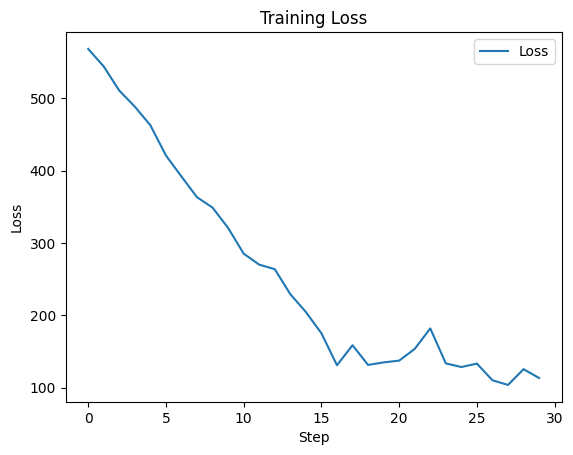

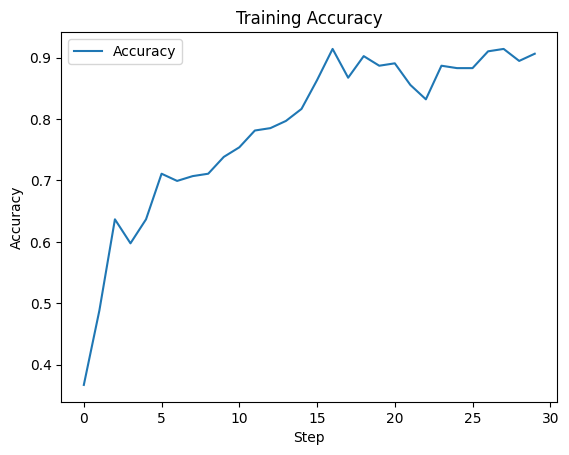

In [52]:
import matplotlib.pyplot as plt

plt.plot(loss_history, label='Loss')
plt.title('Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(accuracy_history, label='Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [53]:
def compute_accuracy(neural_net, x_data, y_true):
    pred = neural_net(x_data)
    correct_predictions = tf.equal(tf.argmax(pred, 1), tf.cast(y_true, tf.int64))
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    return accuracy

test_accuracy = compute_accuracy(neural_net, x_test, y_test).numpy()
print(f'Test Accuracy: {test_accuracy}')

test_results = neural_net(x_test)
predictions = tf.argmax(test_results, axis=1)

correct_predictions = tf.equal(predictions, y_test)
incorrect_predictions = tf.not_equal(predictions, y_test)

print(f'Correct Predictions: {tf.reduce_sum(tf.cast(correct_predictions, tf.int32)).numpy()}')
print(f'Incorrect Predictions: {tf.reduce_sum(tf.cast(incorrect_predictions, tf.int32)).numpy()}')

Test Accuracy: 0.8946999907493591
Correct Predictions: 8947
Incorrect Predictions: 1053


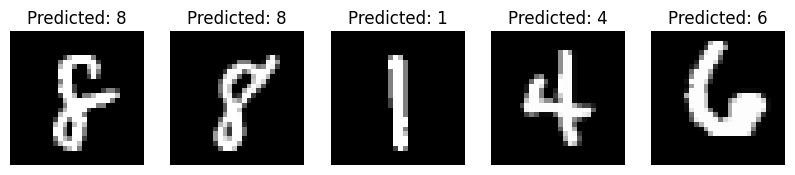

In [54]:
num_test_images = 5
random_indices = np.random.choice(len(x_test), num_test_images, replace=False)
test_images = x_test[random_indices]
test_labels = y_test[random_indices]

predictions = neural_net(test_images)
predicted_labels = tf.argmax(predictions, axis=1).numpy()

plt.figure(figsize=(10, 4))
for i in range(num_test_images):
    plt.subplot(1, num_test_images, i + 1)
    plt.imshow(test_images[i].reshape(28, 28), cmap='gray')
    plt.title(f'Predicted: {predicted_labels[i]}')
    plt.axis('off')
plt.show()